In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
hw_monthly = pd.read_csv("/stats/central_science/hw_trends/monthly_hw_2011_2019.csv",
                        parse_dates=['month'])

In [8]:
hw_monthly.head()

,month,hw
0,2011-01-01,6
1,2011-02-01,8
2,2011-03-01,9
3,2011-04-01,12
4,2011-05-01,15


In [35]:
hw_yearly_gr = hw_monthly[hw_monthly['month'] < pd.to_datetime('2019-08-01')] \
                                         .groupby(pd.Grouper(key='month', freq='A'))

In [36]:
years_begin = hw_yearly_gr.first().to_numpy()
years_end = hw_yearly_gr.last().to_numpy()

In [37]:
# (hw_yearly_gr.first() - hw_yearly_gr.last().shift()) / hw_yearly_gr.last().shift()
new_year_diff = (years_begin[1:] - years_end[:-1]) / years_end[:-1]

In [38]:
new_year_diff = pd.Series(new_year_diff.flatten(), index=pd.date_range('2011-12-31', freq='A-JAN', periods=8))

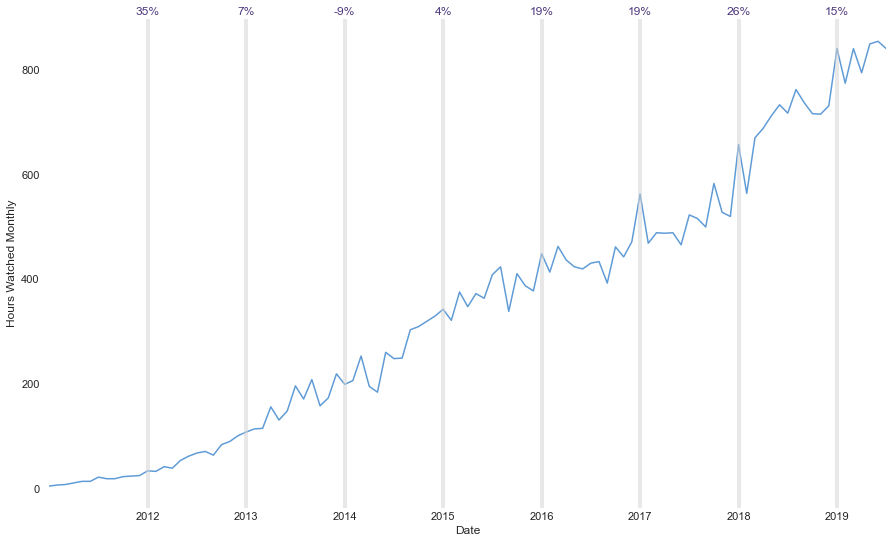

In [54]:
fig, ax = plt.subplots(figsize=(15,9))
hw_monthly[hw_monthly['month'] < pd.to_datetime('2019-08-01')].set_index('month').plot(ax=ax, color='#5f9bd6')
for date, diff in new_year_diff.iteritems():
    ax.axvline(date, *(0, 875), lw=4, alpha=0.5, color='lightgray')
    ax.text(date, 900, f'{diff:.0%}', size='medium', ha='center', va='bottom', color='#4C367C')
ax.set_xlabel('Date')
ax.set_ylabel('Hours Watched Monthly')
ax.legend([], frameon=False)
ax.set(frame_on=False, xticks=new_year_diff.index)
#ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params('x', which='major', length=0)
ax.xaxis.set_minor_locator(plt.NullLocator())
#fig.autofmt_xdate()
plt.show()

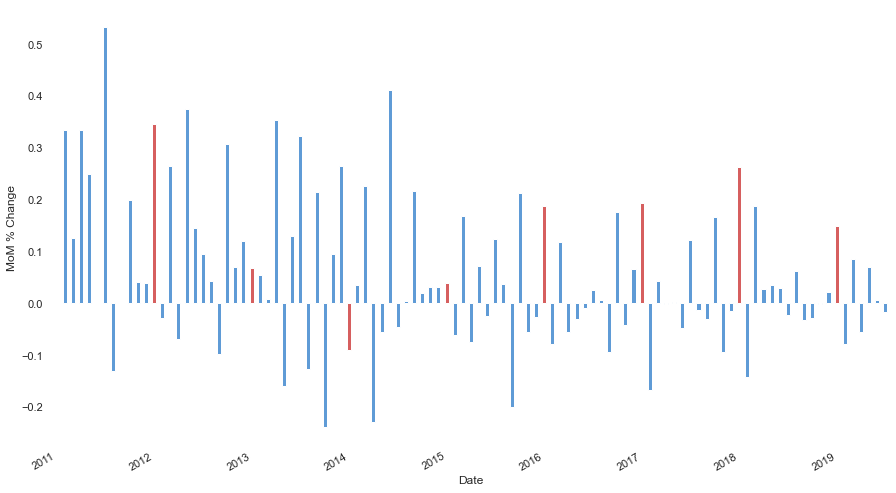

In [97]:
import matplotlib.dates as mdates
hw_monthly_short = hw_monthly[hw_monthly['month'] < pd.to_datetime('2019-08-01')]
is_jan = hw_monthly_short['month'].dt.month == 1
fig, ax = plt.subplots(figsize=(15,9))
# perc_diff = 100 * (hw_monthly_short['hw'] / hw_monthly_short['hw'].shift() - 1))                  
hw_monthly_short.assign(perc_diff=hw_monthly_short['hw'].pct_change()) \
                .plot(
    'month',
    'perc_diff',
    kind='bar',
    stacked=True,
    color=is_jan.map({True: '#d65f5f', False: '#5f9bd6'}), # colored Jan
    ax=ax
)

ax.set(frame_on=False, xlabel='Date', ylabel='MoM % Change')
ax.legend([], frameon=False)
ticks = ax.set_xticklabels([f'{x:%Y}' if x.month == 1 else '' for x in hw_monthly_short['month']])
#ax.xaxis.set_major_locator(plt.MaxNLocator(8))

ax.tick_params(axis='x', which='major', length=0)
fig.autofmt_xdate();

## Daily HW

In [2]:
daily_hw = pd.read_csv('/stats/central_science/LTV/Data/hours_watched_daily.csv',
                      parse_dates=['timestamp'])

In [103]:
daily_hw.head()

,metric_name,timestamp,metric_value
0,hours_watched,2015-01-02,10209821.05
1,hours_watched,2015-01-03,10780762.22
2,hours_watched,2015-01-04,11550597.92
3,hours_watched,2015-01-05,11069369.09
4,hours_watched,2015-01-06,11276060.99


In [15]:
def daily_HW(df, year):
    daily_hw = df.assign(
        hw=df['metric_value'] / 1e6
    ).query(f"timestamp >= '{year-1}-11-01' & timestamp < '{year}-03-01'") 

    fig, ax = plt.subplots(figsize=(15,9))
    
    daily_hw.query(f"timestamp < '{year}-01-01'").plot('timestamp', 'hw', color='#d65f5f', ax=ax)
    daily_hw.query(f"timestamp >= '{year}-01-01'").plot('timestamp', 'hw', color='#5f9bd6', ax=ax)
    
    ax.legend([], frameon=False)
    ax.set(**{'title': year,
              'xlabel': 'Date',
              'ylabel': 'Daily HW (MM)'})
    fig.autofmt_xdate();

### 2016

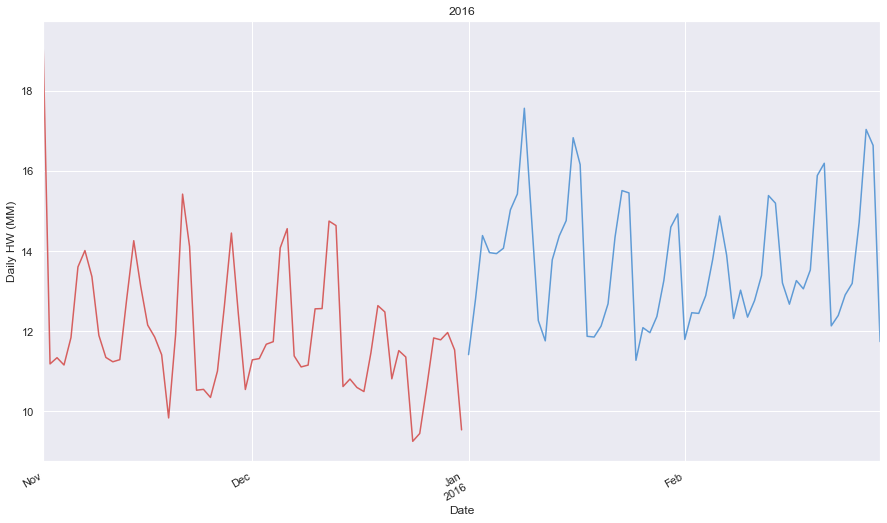

In [16]:
daily_HW(daily_hw, 2016)

### 2017

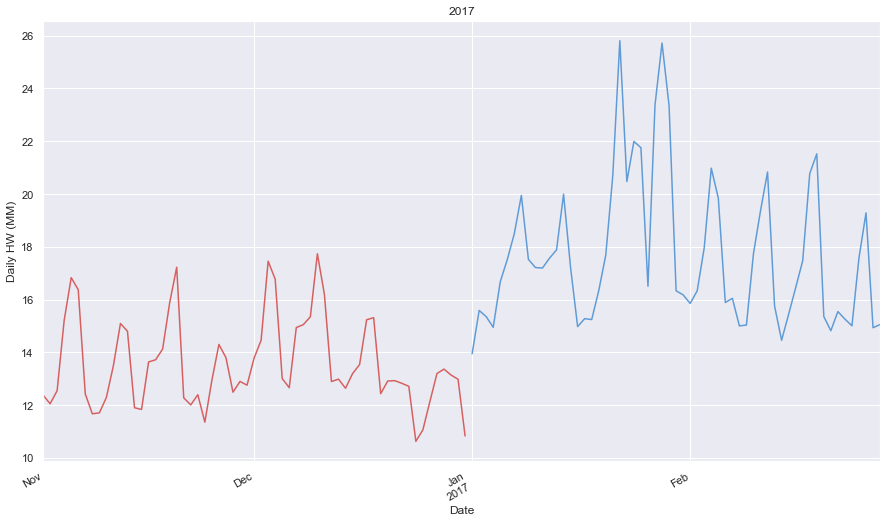

In [17]:
daily_HW(daily_hw, 2017)

### 2018

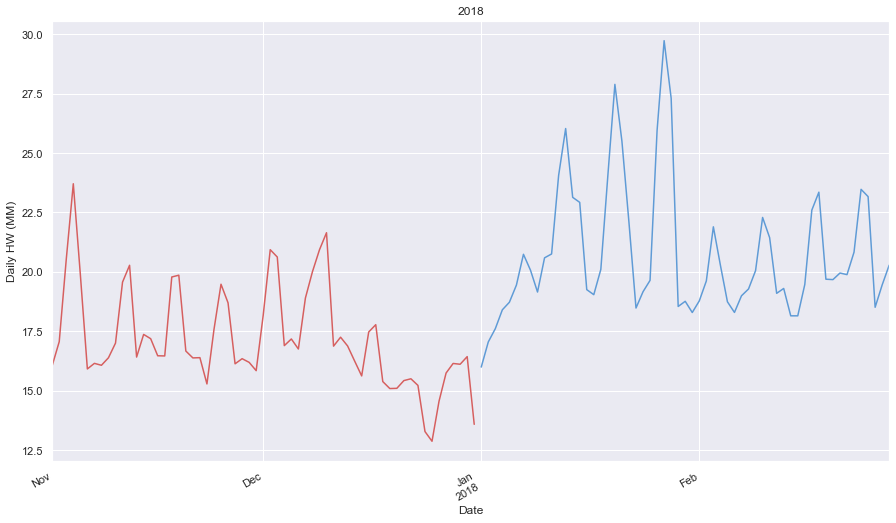

In [18]:
daily_HW(daily_hw, 2018)

### 2019

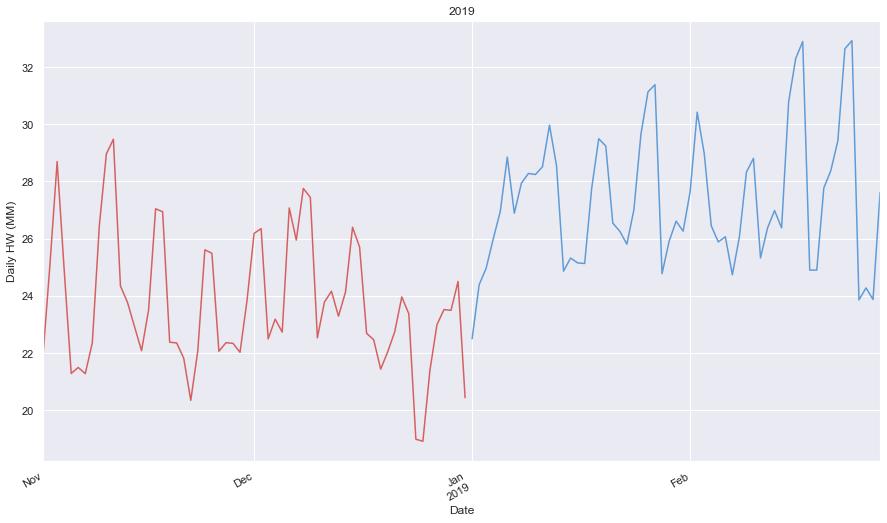

In [19]:
daily_HW(daily_hw, 2019)

In [20]:
hw_delta = pd.read_csv('/stats/central_science/hw_trends/hw_monthly_delta.csv')

In [331]:
months = dict(zip(range(1,13), ['jan', 'feb', 'mar', 'apr',
                                'may', 'jun', 'jul', 'aug',
                                'sep', 'oct', 'nov', 'dec']))

In [335]:
# eoy —  end of fiscal year
hw_monthly.query("month > '2011-11-01' & month <= '2019-01-01'") \
 .groupby([hw_monthly['month'].dt.year, hw_monthly['month'].dt.month]) \
              .sum() \
              .diff(1) \
              .unstack() \
              .dropna().astype(int) \
              .droplevel(level=0, axis=1) \
              .join(hw_monthly.groupby([hw_monthly['month'].dt.to_period('Q-SEP').dt.qyear]).sum()) \
              .reset_index() \
              .rename(columns={**{'hw': 'eoy', 'month': 'year'}, **months})
              

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,eoy
0,2012,9,-1,9,-3,15,8,6,3,-7,20,6,11,551
1,2013,7,6,1,41,-25,17,48,-25,37,-50,15,46,1634
2,2014,-20,7,47,-58,-11,76,-12,1,54,6,10,10,2659
3,2015,13,-21,54,-28,25,-9,45,15,-85,72,-23,-10,4258
4,2016,71,-35,49,-26,-13,-4,11,3,-41,69,-19,29,5042
5,2017,91,-94,20,-1,1,-23,57,-7,-16,83,-55,-8,5880
6,2018,137,-93,106,18,24,21,-16,45,-25,-21,-1,16,7871


In [362]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [363]:
model = ols('eoy ~ jan', data=hw_delta.query('year >= 2016')).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
jan,1.318368e+06,1.0,19.116264,0.143144
Residual,6.896579e+04,1.0,NaN,NaN


In [364]:
model.summary()

/Users/popov/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    eoy   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     19.12
Date:                Thu, 30 Dec 2021   Prob (F-statistic):              0.143
Time:                        17:31:56   Log-Likelihood:                -19.321
No. Observations:                   3   AIC:                             42.64
Df Residuals:                       1   BIC:                             40.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1082.0428    567.501     -1.907      0.308   -8292.831    6128.746
jan           23.9904      5.487      4.372      0.143     -45.729      93.709
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.902
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.435
Skew:                          -0.554   Prob(JB):                        0.805
Kurtosis:                       1.500   Cond. No.                         387.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [360]:
#X = sm.add_constant(hw_delta.query('year >= 2016')['jan'])
#y = hw_delta.query('year >= 2016')['eoy']

In [370]:
aov_table.assign(pct_exp=aov_table['sum_sq'].div(aov_table['sum_sq'].sum()).mul(100))

,sum_sq,df,F,PR(>F),pct_exp
jan,1.318368e+06,1.0,19.116264,0.143144,95.028898
Residual,6.896579e+04,1.0,NaN,NaN,4.971102


In [2]:
hw_by_tier = pd.read_csv('/stats/central_science/hw_trends/hw_monthly_by_tier.csv',
                        parse_dates=['month'])

In [3]:
hw_by_tier.head()

,month,ccu_tier_past_90_days_wp,hw
0,2015-01-01,premium,73
1,2015-02-01,premium,62
2,2015-03-01,T0: 0-2 CCU,4
3,2015-03-01,T1: 3-10 CCU,10
4,2015-03-01,T2: 11-100 CCU,26


In [3]:
def HW_by_tier(df, year):
    df['delta'] = df.groupby('ccu_tier_past_90_days_wp')['hw'] \
                      .transform(lambda x: x - x.shift())
    df = df.query(f"month >= '{year-1}-12-31' & month < '{year}-01-31'") 

    fig, ax = plt.subplots(figsize=(15,9))
    sns.set(style='white')
    sns.barplot(
        x='ccu_tier_past_90_days_wp',
        y='delta',
        data=df,
        #palette="ch:.25", ax=ax
    )
    ax.tick_params(bottom=False, left=True)

    ax.set(**{'frame_on': False,
              'title': year,
              'xlabel': 'January',
              'ylabel': 'HW Growth since December (MM)'})
    plt.show()

### 2016

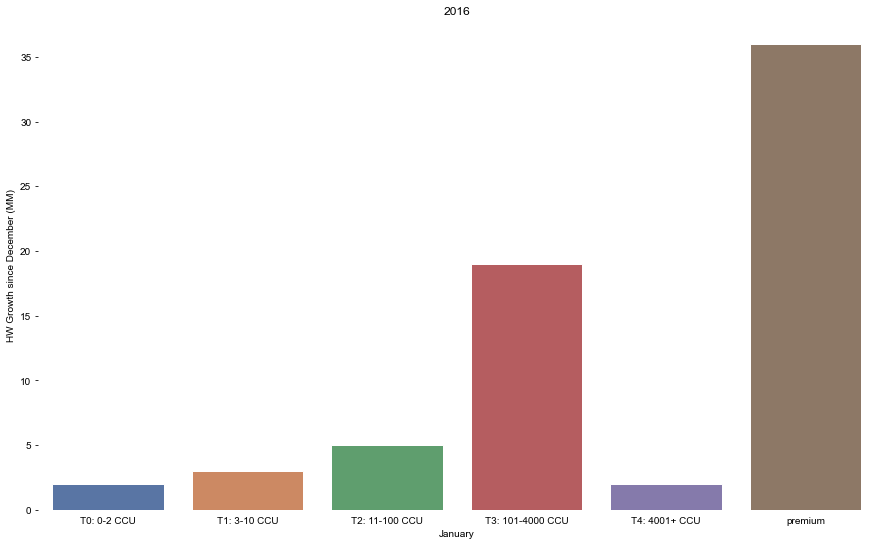

In [4]:
HW_by_tier(hw_by_tier, 2016)

### 2017

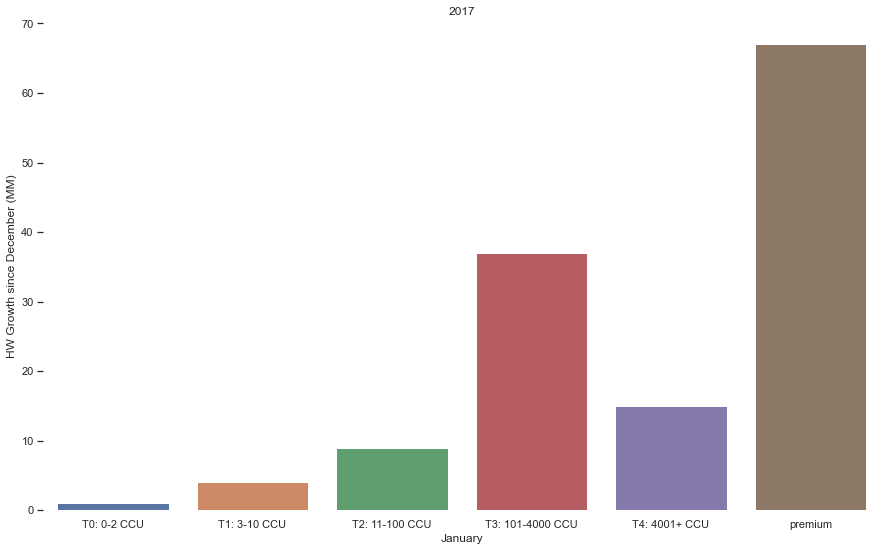

In [5]:
HW_by_tier(hw_by_tier, 2017)

### 2018

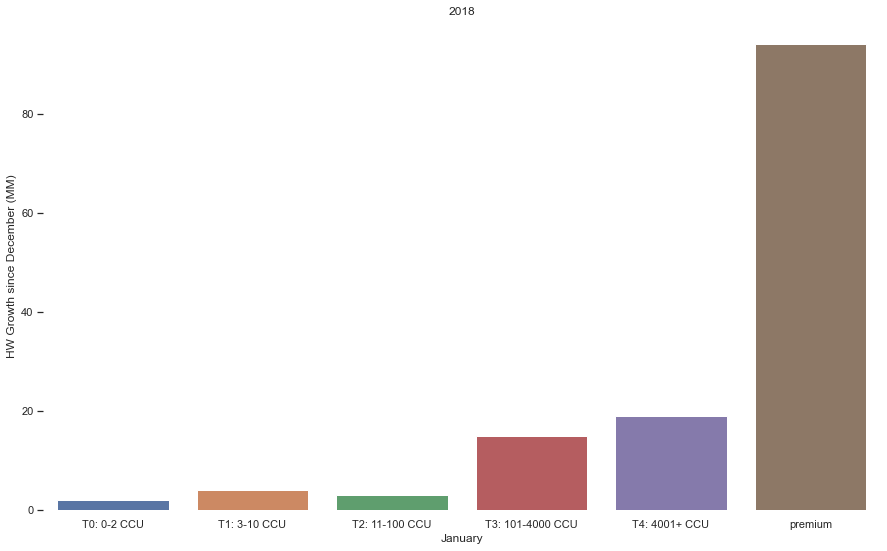

In [6]:
HW_by_tier(hw_by_tier, 2018)

### 2019

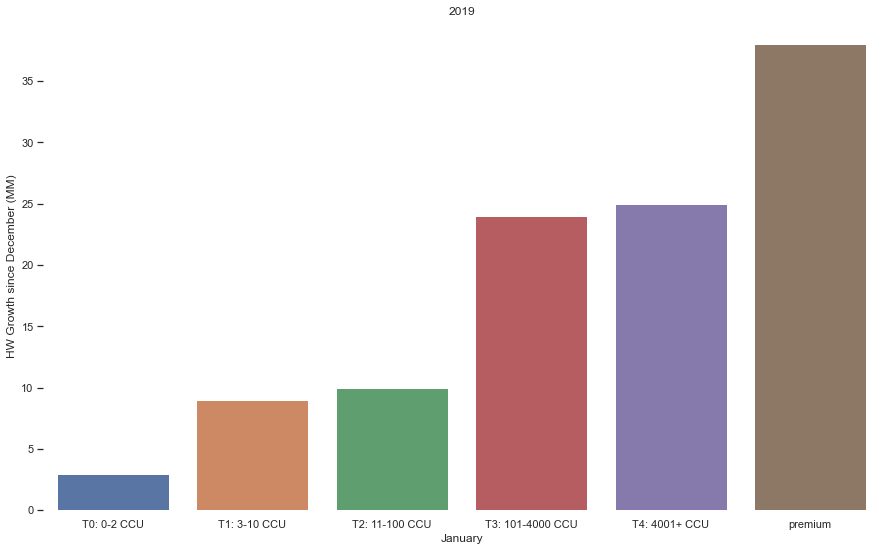

In [7]:
HW_by_tier(hw_by_tier, 2019)

In [17]:
davs_by_lifecycle = pd.read_csv('/stats/central_science/hw_trends/monthly_dav_by_lifecycle.csv',
                               parse_dates=['month'])

In [3]:
davs_by_lifecycle.head()

,month,lifecycle_stage,avg_dav
0,2015-12-01 00:00:00,born,336644
1,2015-12-01 00:00:00,new,534902
2,2015-12-01 00:00:00,occasional,1519727
3,2015-12-01 00:00:00,reengaged,321144
4,2015-12-01 00:00:00,regular,3031314


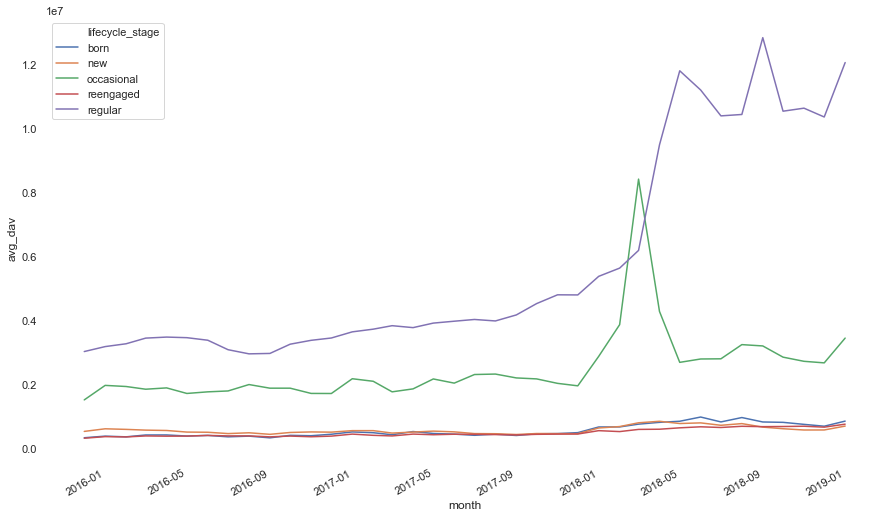

In [25]:
fig, ax = plt.subplots(figsize=(15,9))
sns.set(style='white')
sns.lineplot(
        x='month',
        y='avg_dav',
        hue='lifecycle_stage',
        data=davs_by_lifecycle,
        ax=ax
    )
ax.set(**{'frame_on': False})
#ticks = ax.set_xticklabels([f'{x:%Y}' if x.month == 1 else '' for x in davs_by_lifecycle['month']])
#ax.xaxis.set_major_locator(plt.MaxNLocator(8))
fig.autofmt_xdate();

## DAV Growth

In [41]:
def DAV_growth(df, year):
    df['delta'] = df.groupby('lifecycle_stage')['avg_dav'] \
                                       .transform(lambda x: x - x.shift())
    df = df.query(f"month >= '{year-1}-12-31' & month < '{year}-01-31'") 

    fig, ax = plt.subplots(figsize=(15,9))
    sns.set(style='white')
    sns.barplot(
        x='lifecycle_stage',
        y='delta',
        data=df,
        saturation=.5,
        #palette="ch:.25",
        ax=ax
    )
    ax.tick_params(bottom=False, left=True)

    ax.set(**{'frame_on': False,
              'title': year,
              'xlabel': 'January',
              'ylabel': 'DAV Growth since December (MM)'})
    plt.show()

### 2016

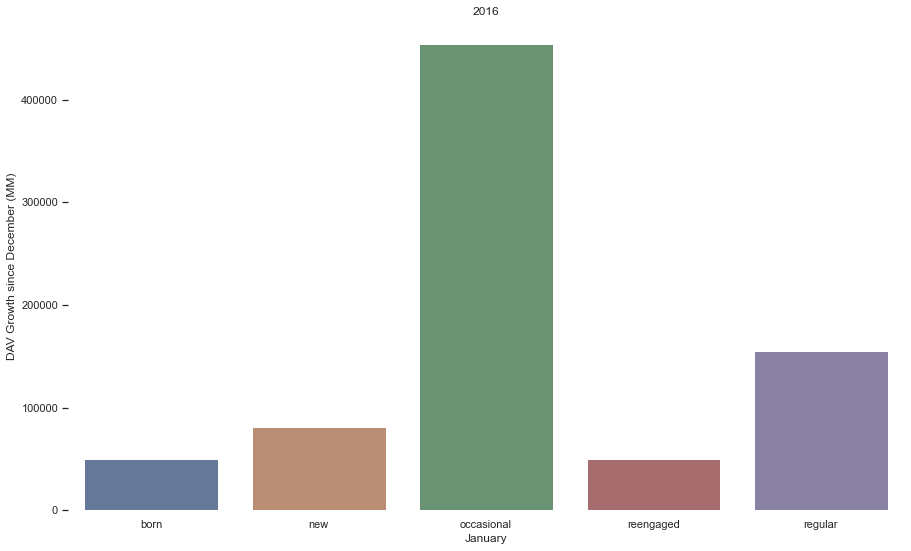

In [42]:
DAV_growth(davs_by_lifecycle, 2016)

### 2017

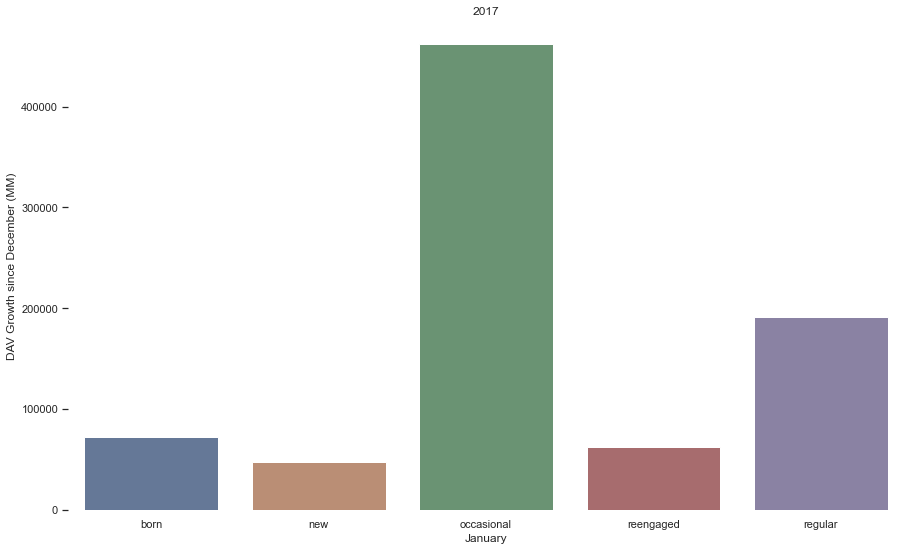

In [44]:
DAV_growth(davs_by_lifecycle, 2017)

### 2018

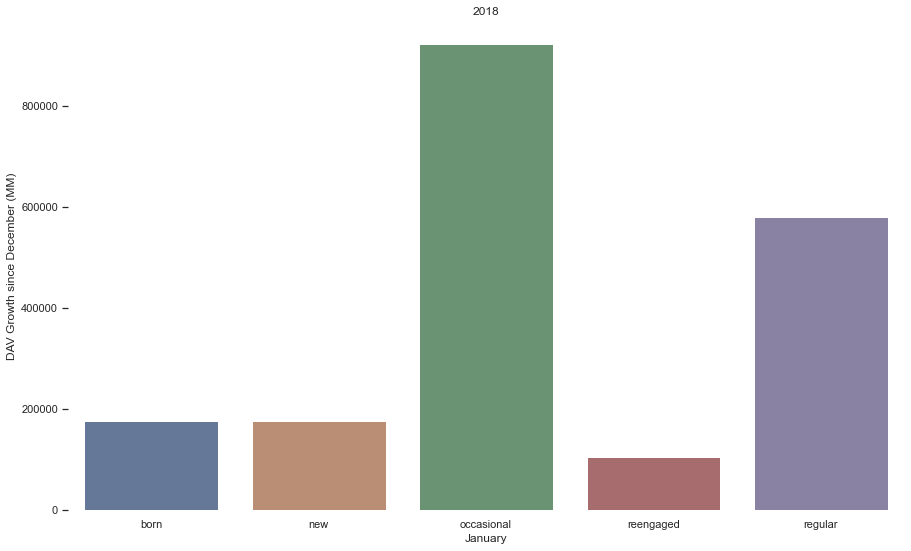

In [45]:
DAV_growth(davs_by_lifecycle, 2018)

### 2019

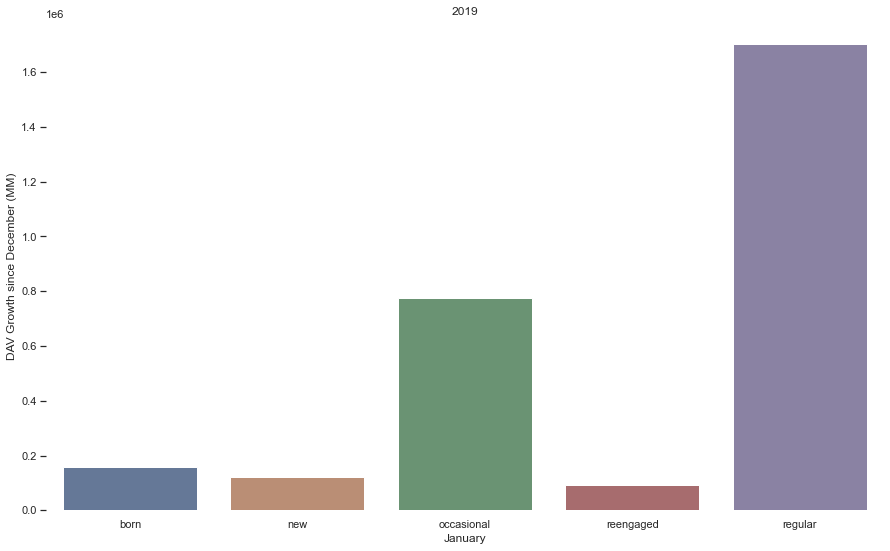

In [46]:
DAV_growth(davs_by_lifecycle, 2019)

## MAV Growth

In [85]:
davs_by_lifecycle

,month,lifecycle_stage,avg_dav,delta,mav_delta
0,2015-12-01,born,336644,NaN,NaN
1,2015-12-01,new,534902,NaN,0.149333
2,2015-12-01,occasional,1519727,NaN,-0.056852
3,2015-12-01,reengaged,321144,NaN,0.159304
4,2015-12-01,regular,3031314,NaN,0.002262
...,...,...,...,...,...
185,2019-01-01,born,856532,159278.0,0.229980
186,2019-01-01,new,700973,121564.0,-0.178988
187,2019-01-01,occasional,3452244,774885.0,0.008977
188,2019-01-01,reengaged,761164,93552.0,-0.025920


In [86]:
davs_by_lifecycle.merge(active_days_by_lifecycle,  on='lifecycle_stage').sort_values(by='month')

,month,lifecycle_stage,avg_dav,delta,mav_delta,avg_days
0,2015-12-01,born,336644,NaN,NaN,1.0000
38,2015-12-01,new,534902,NaN,0.149333,6.1088
114,2015-12-01,reengaged,321144,NaN,0.159304,2.5580
76,2015-12-01,occasional,1519727,NaN,-0.056852,6.9416
152,2015-12-01,regular,3031314,NaN,0.002262,20.3018
...,...,...,...,...,...,...
151,2019-01-01,reengaged,761164,93552.0,-0.025920,2.5580
75,2019-01-01,new,700973,121564.0,-0.178988,6.1088
37,2019-01-01,born,856532,159278.0,0.229980,1.0000
113,2019-01-01,occasional,3452244,774885.0,0.008977,6.9416


In [49]:
active_days_by_lifecycle = pd.DataFrame({
    'lifecycle_stage': ("born", "new", "occasional", "reengaged", "regular"),
    'avg_days': (1.0, 6.1088, 6.9416, 2.558, 20.3018)
})

In [134]:
def MAV_growth(df, year):
    df['mav_delta'] = df.merge(active_days_by_lifecycle,  on='lifecycle_stage', how='left') \
                                            .eval('mav = avg_dav / avg_days * 31') \
                                            .groupby('lifecycle_stage')['mav'] \
                                            .transform(lambda x: x / x.shift() - 1) \
                                            .div(1e6)
    df = df.query(f"month >= '{year-1}-12-31' & month < '{year}-01-31'") 

    fig, ax = plt.subplots(figsize=(15,9))
    sns.set(style='white')
    sns.barplot(
        x='lifecycle_stage',
        y='mav_delta',
        data=df,
        saturation=.5,
        ax=ax
    )
    ax.tick_params(bottom=False, left=True)

    ax.set(**{'frame_on': False,
              'title': year,
              'xlabel': 'January',
              'ylabel': 'MAV Growth since December (MM)'})
    plt.show()

### 2016

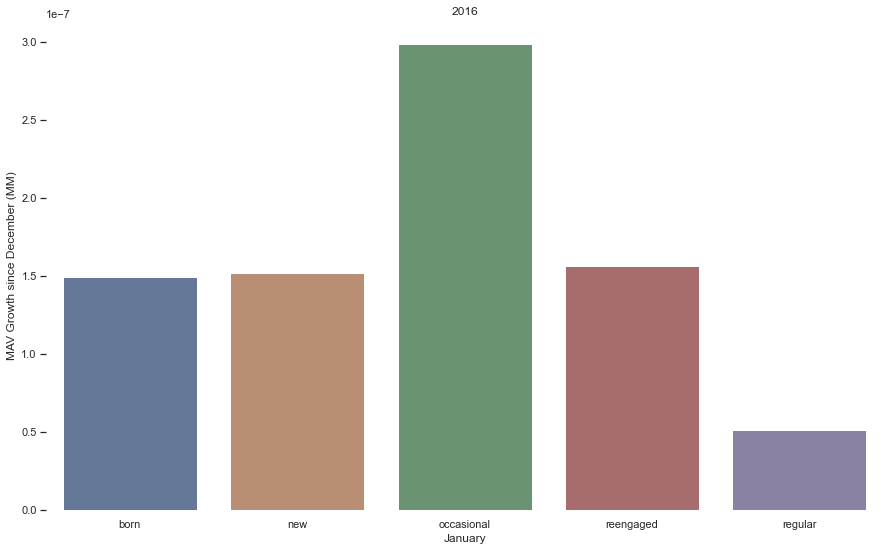

In [135]:
MAV_growth(davs_by_lifecycle, 2016)

### 2017

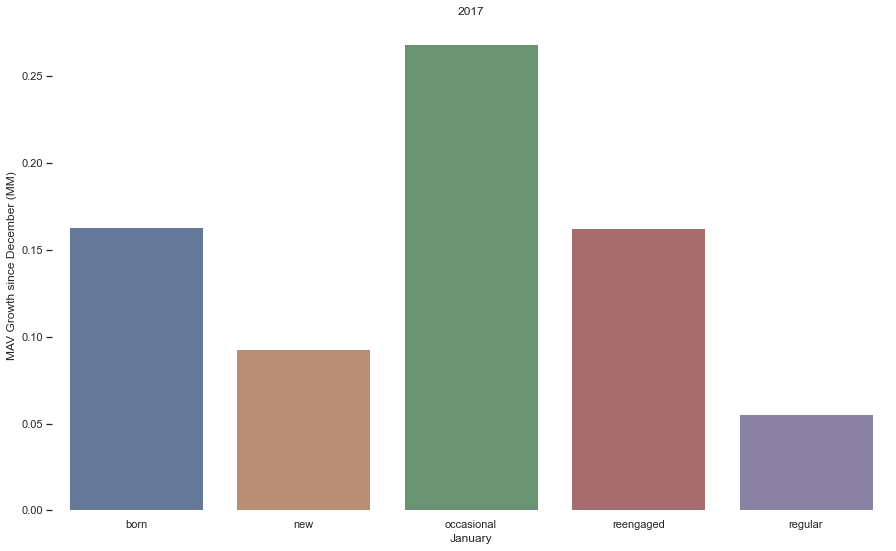

In [94]:
MAV_growth(davs_by_lifecycle, 2017)

### 2018

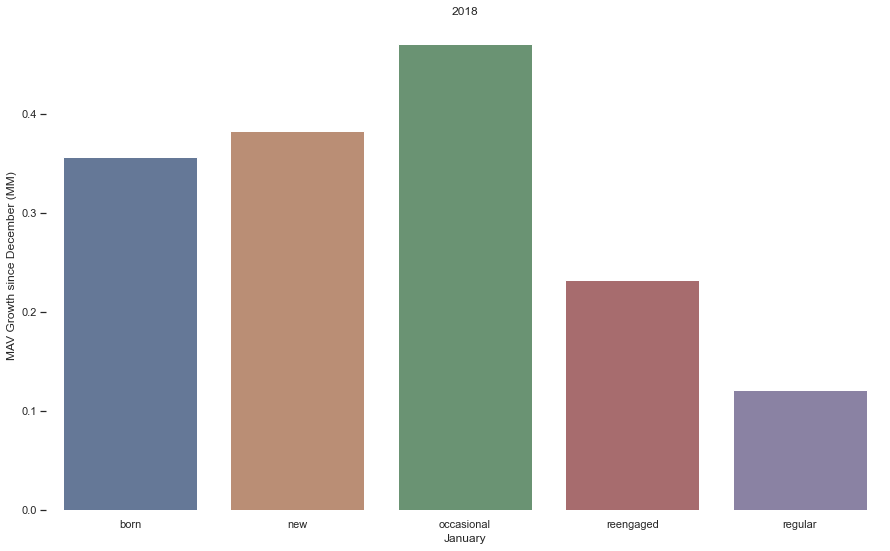

In [96]:
MAV_growth(davs_by_lifecycle, 2018)

### 2019

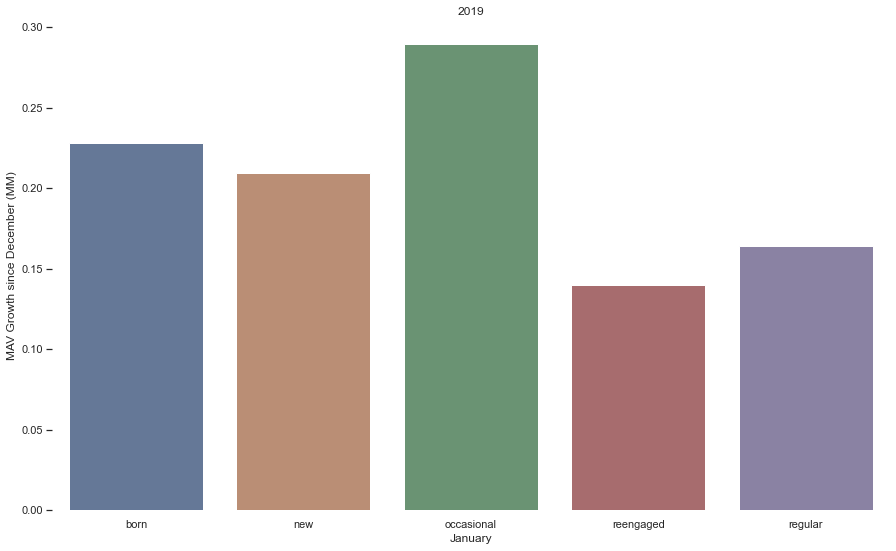

In [97]:
MAV_growth(davs_by_lifecycle, 2019)

In [99]:
hw_by_country = pd.read_csv('/stats/central_science/hw_trends/monthly_hw_by_country_tier.csv',
                           parse_dates=['month'])
hw_by_country.head()

,month,country_tier,hours_watched
0,2015-01-01,T1,1.260500e+08
1,2015-01-01,T2,8.920733e+07
2,2015-01-01,T3,1.260768e+08
3,2015-02-01,T1,1.163500e+08
4,2015-02-01,T2,7.978706e+07


In [107]:
hw_total = hw_by_country.groupby(['month']).agg(hw_total=('hours_watched', 'sum')).reset_index()

## Area chart

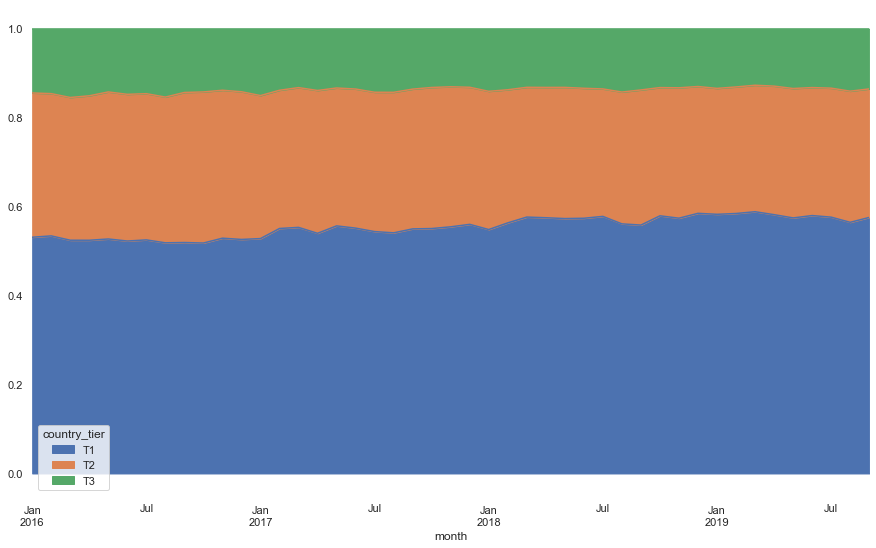

In [133]:
fig, ax = plt.subplots(figsize=(15,9))
hw_by_country \
    .merge(hw_total, how='left', on='month') \
    .eval('prop_hw = hours_watched / hw_total') \
    .query('month >= "2015-12-31"') \
    .pivot_table(index='month', columns='country_tier', values='prop_hw') \
    .plot.area(ax=ax)

ax.set(frame_on=False)
plt.show()

## HW Growth

In [172]:
def HW_growth(df, year):
    df['hw_delta'] = df.groupby('country_tier')['hours_watched'] \
                        .transform(lambda x: x / x.shift())
    df = df.query(f"month >= '{year-1}-12-31' & month < '{year}-01-31'") 
    df.loc[:,'hours_watched'] = df['hours_watched'] / 1e6
    fig, ax = plt.subplots(figsize=(15,9))
    sns.set(style='white')
    sns.barplot(
        x='country_tier',
        y='hours_watched',
        data=df,
        saturation=.5,
        ax=ax
    )
    ax.tick_params(bottom=False, left=True)

    ax.set(**{'frame_on': False,
              'ylim': [0, 500],
              'title': year,
              'xlabel': 'January',
              'ylabel': 'HW Growth since December (MM)'})
    plt.show()

### 2016

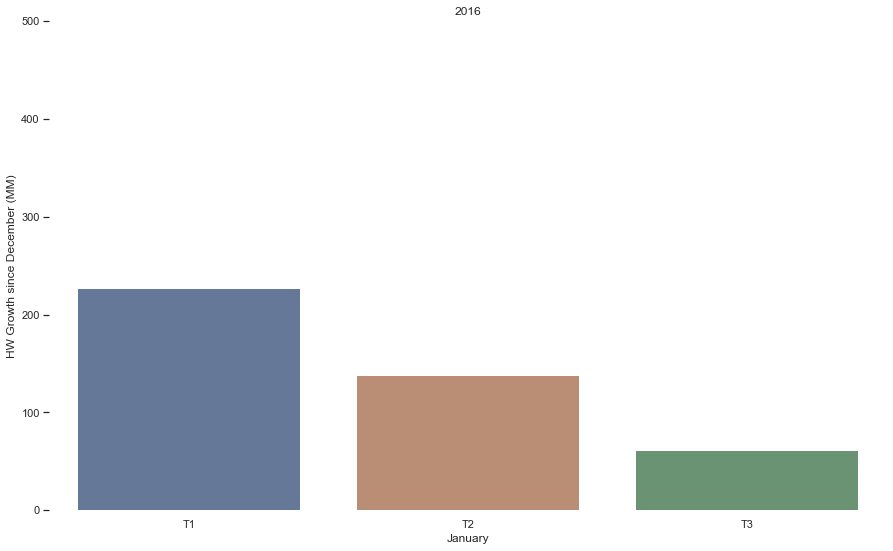

In [174]:
HW_growth(hw_by_country, 2016)

### 2017

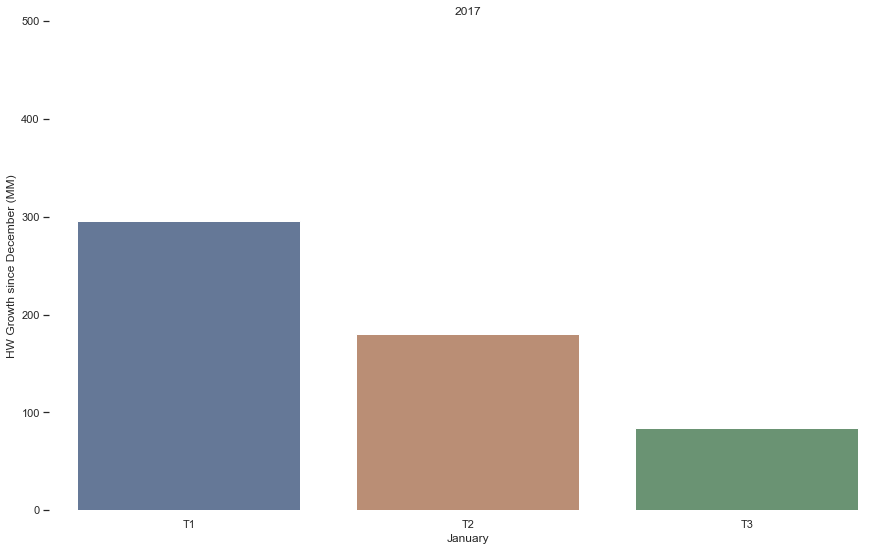

In [175]:
HW_growth(hw_by_country, 2017)

### 2018

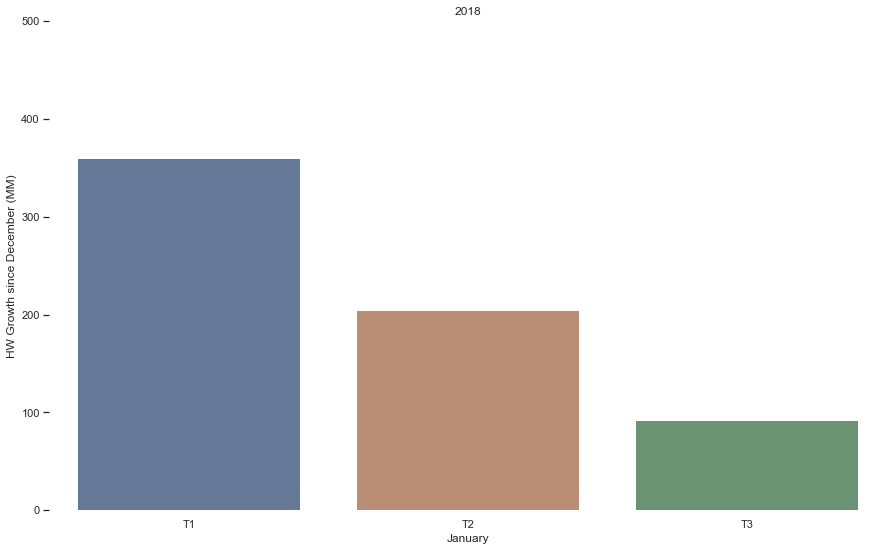

In [176]:
HW_growth(hw_by_country, 2018)

### 2019

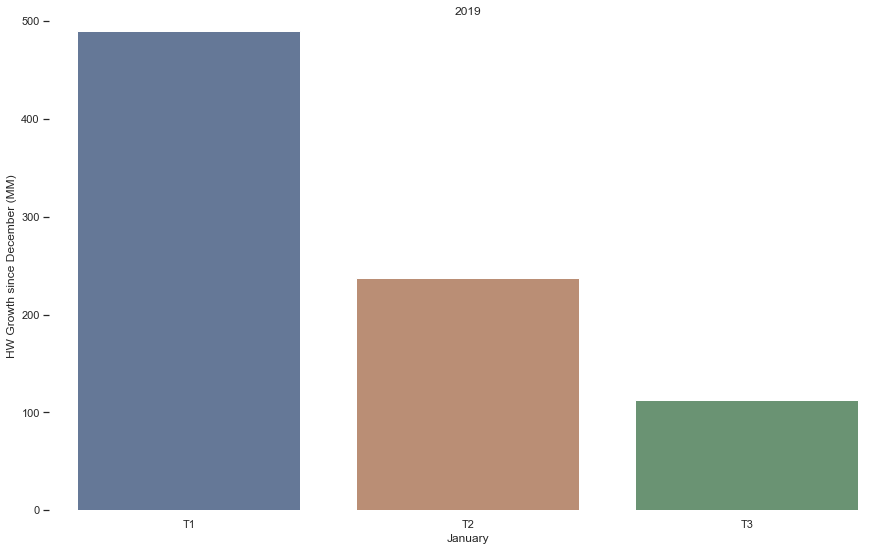

In [177]:
HW_growth(hw_by_country, 2019)

In [180]:
hw_by_country['growth'] = hw_by_country \
                 .groupby('country_tier')['hours_watched'] \
                 .transform(lambda x: x - x.shift() - 1)

## HB vs Viewers

In [15]:
hb_vs_viewers = pd.read_csv('/stats/central_science/hw_trends/hb_vs_viewers.csv',
                           parse_dates=['day'])
hb_vs_viewers.head()

,day,minutes_broadcast,creators_live,visitors
0,2015-11-01,23353435,188134,11124724.0
1,2015-11-02,20554559,165973,8987423.0
2,2015-11-03,20959362,166376,9179076.0
3,2015-11-04,20735175,166246,8997203.0
4,2015-11-05,22480754,192565,9926481.0


In [209]:
def creators_viewers_ratio(df, year):
    fig, ax = plt.subplots(figsize=(15,9))
    df.assign(crv_ratio=df['creators_live'] / df['visitors']) \
          .query(f'day >= "{year-1}-11-30" & day < "{year}-01-31"') \
          .plot(x='day', y='crv_ratio', ax=ax)
    ax.axvline(f'{year-1}-12-25', *(0, 1.), lw=7, alpha=0.5, color='darkgreen')
    ax.axvline(f'{year-1}-12-25', *(0, 1.), lw=1, color='red')
    ax.tick_params(bottom=False, left=True)
    ax.legend([], frameon=False)
    ax.set(**{'frame_on': False,
              'ylim': [0, 0.03],
              'title': year,
              'xlabel': 'Date',
              'ylabel': 'Creators / Viewers Ratio'})
    plt.show()

### 2016

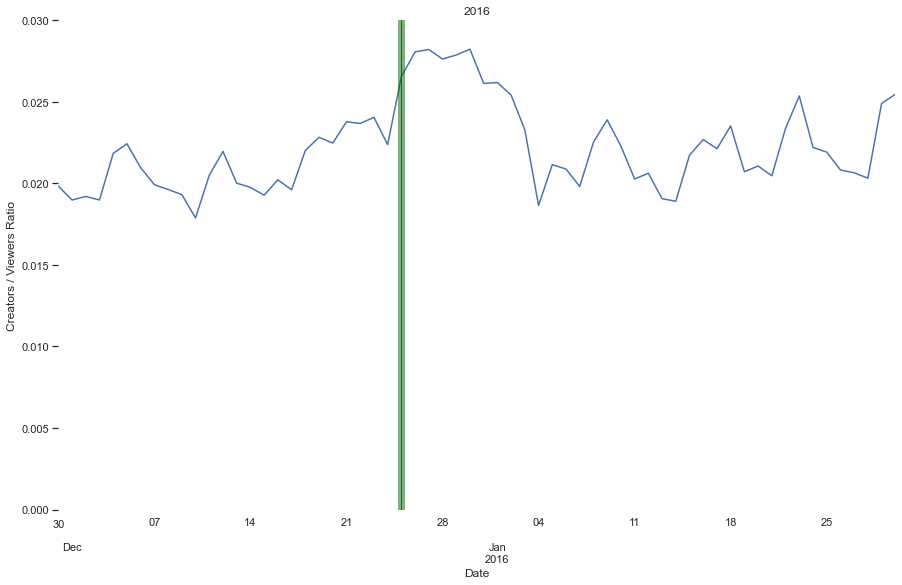

In [210]:
creators_viewers_ratio(hb_vs_viewers, 2016)

### 2017

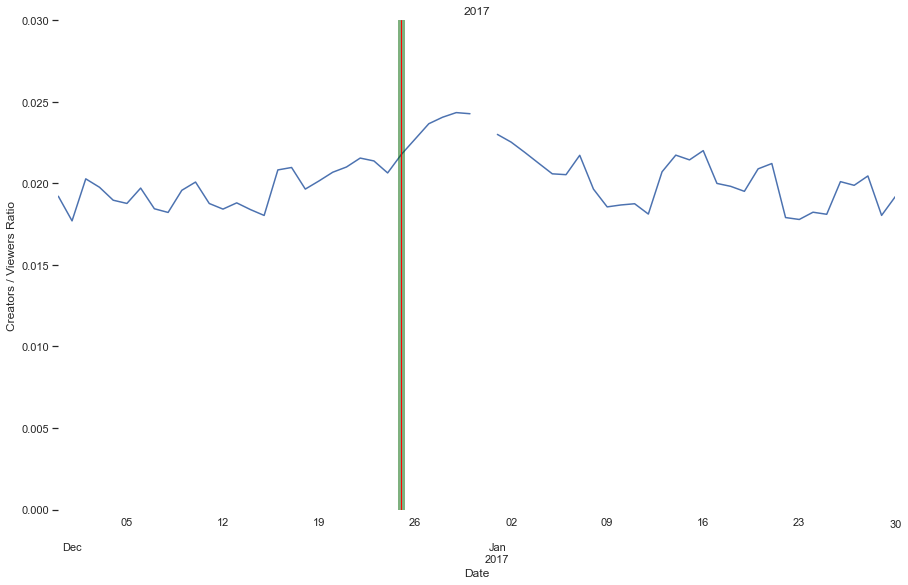

In [211]:
creators_viewers_ratio(hb_vs_viewers, 2017)

### 2018

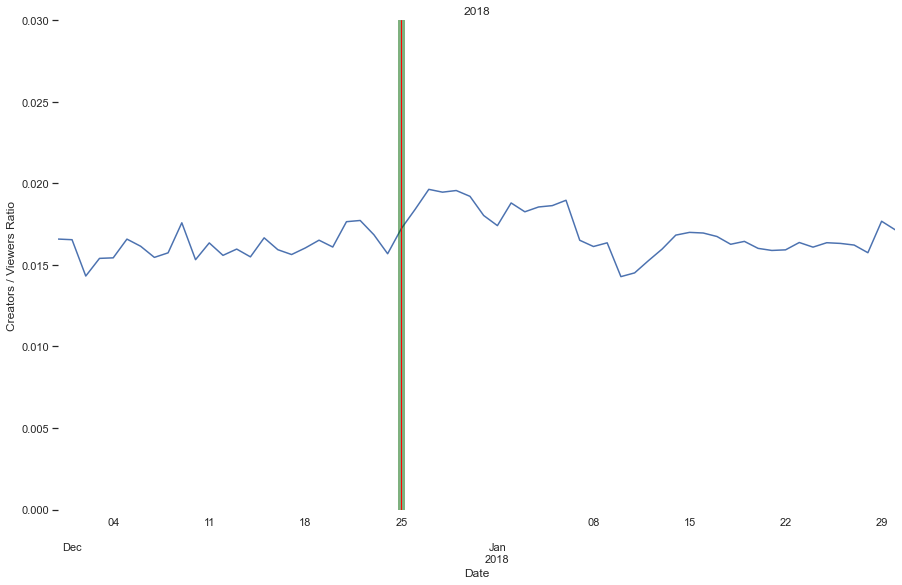

In [212]:
creators_viewers_ratio(hb_vs_viewers, 2018)

### 2019

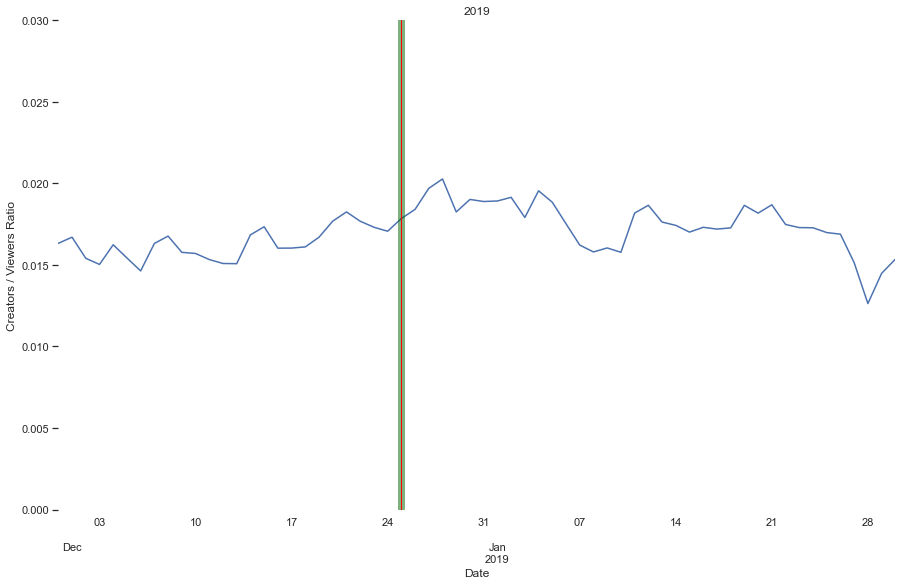

In [213]:
creators_viewers_ratio(hb_vs_viewers, 2019)

In [216]:
weekly_premium_hw = pd.read_csv('/stats/central_science/hw_trends/weekly_premium_hw.csv',
                               parse_dates=['week'])
weekly_premium_hw.head()

,week,viewer_lifecycle_stage,hw
0,2015-08-31,born,5.888632e+05
1,2015-08-31,new,1.318825e+06
2,2015-08-31,occasional,3.563307e+06
3,2015-08-31,reengaged,3.883610e+05
4,2015-08-31,regular,5.269352e+06


In [228]:
monthly_premium_hw = pd.read_csv('/stats/central_science/hw_trends/monthly_premium_hw.csv',
                                parse_dates=['month'])
monthly_premium_hw.head()

,month,viewer_lifecycle_stage,hw
0,2015-09-01,born,2.614364e+06
1,2015-09-01,new,5.868498e+06
2,2015-09-01,occasional,1.614308e+07
3,2015-09-01,reengaged,1.749953e+06
4,2015-09-01,regular,2.634349e+07


In [223]:
monthly_premium_hw['diff'] = monthly_premium_hw.groupby('viewer_lifecycle_stage')['hw'] \
                                               .transform(lambda x: x - x.shift())
monthly_premium_hw.query(
    "(month >= '2015-12-01' & month <= '2016-01-31') | \
     (month >= '2016-12-01' & month <= '2017-01-31') | \
     (month >= '2017-12-01' & month <= '2018-01-31') | \
     (month >= '2018-12-01' & month <= '2019-01-31')"
)

In [230]:
monthly_premium_hw['hw_growth'] = monthly_premium_hw \
                  .groupby('viewer_lifecycle_stage')['hw'] \
                  .transform(lambda x: x - x.shift())
monthly_total = monthly_premium_hw.groupby('month').agg({'hw_growth': 'sum'})

In [235]:
viewer_transitions_28d = pd.read_csv('/stats/central_science/'
                                     'hw_trends/viewer_transitions_28d.csv', parse_dates=['day'])
viewer_transitions_28d.head()

,day,start_state,end_state,transition,x,n,pc
0,2017-01-04,occasional,reengaged,occasional_reengaged,269097,12711202,0.021170
1,2017-01-04,reengaged,occasional,reengaged_occasional,262184,919945,0.285000
2,2017-01-04,frozen,occasional,frozen_occasional,1969616,187533574,0.010503
3,2017-01-04,occasional,regular,occasional_regular,884544,12711202,0.069588
4,2017-01-04,occasional,frozen,occasional_frozen,3336231,12711202,0.262464


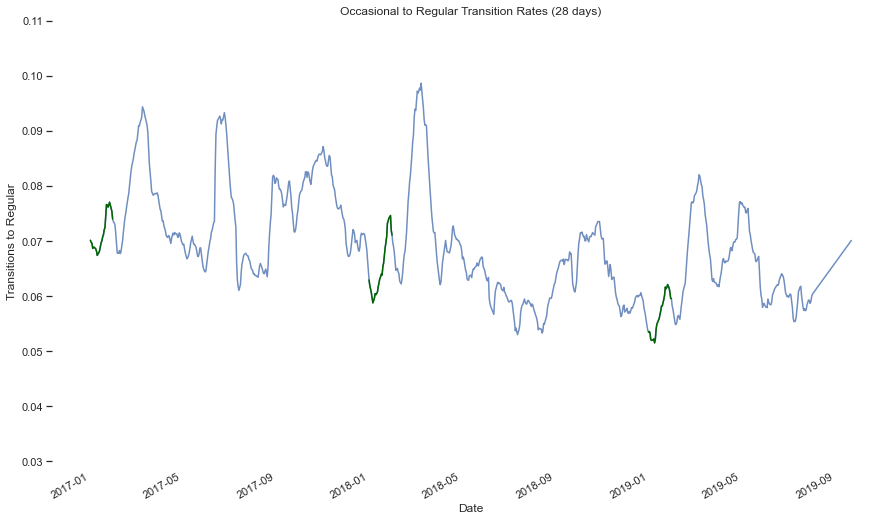

In [255]:
fig, ax = plt.subplots(figsize=(15,9))
viewer_transitions_28d.query('transition == "occasional_regular"').plot(x='day', y='pc', ax=ax, alpha=.8)
for year in (2017, 2018, 2019):
    viewer_transitions_28d.query(f'transition == "occasional_regular" & day.dt.month == 1 & day.dt.year == {year}') \
                          .plot(x='day', y='pc', ax=ax, color='darkgreen')
ax.legend([], frameon=False)
ax.tick_params(bottom=False, left=True)
ax.set(**{'frame_on': False,
          'ylim': [.03, .11],
          'title': 'Occasional to Regular Transition Rates (28 days)',
          'xlabel': 'Date',
          'ylabel': 'Transitions to Regular'})
plt.show()

In [263]:
viewer_transitions_28d

,day,start_state,end_state,transition,x,n,pc
0,2017-01-04,occasional,reengaged,occasional_reengaged,269097,12711202,2.117007e-02
1,2017-01-04,reengaged,occasional,reengaged_occasional,262184,919945,2.849996e-01
2,2017-01-04,frozen,occasional,frozen_occasional,1969616,187533574,1.050274e-02
3,2017-01-04,occasional,regular,occasional_regular,884544,12711202,6.958775e-02
4,2017-01-04,occasional,frozen,occasional_frozen,3336231,12711202,2.624638e-01
...,...,...,...,...,...,...,...
25216,2019-06-05,cold,cold,cold_cold,9196891,153865051,5.977245e-02
25217,2019-06-05,born,new,born_new,18630,5263673,3.539354e-03
25218,2019-06-05,frozen,born,frozen_born,1,729590728,1.370631e-09
25219,2019-06-05,frozen,new,frozen_new,1,729590728,1.370631e-09


In [259]:
regulars = viewer_transitions_28d.query('end_state == "regular"') \
                                 .groupby('day') \
                                 .agg(total=('x', 'sum'))

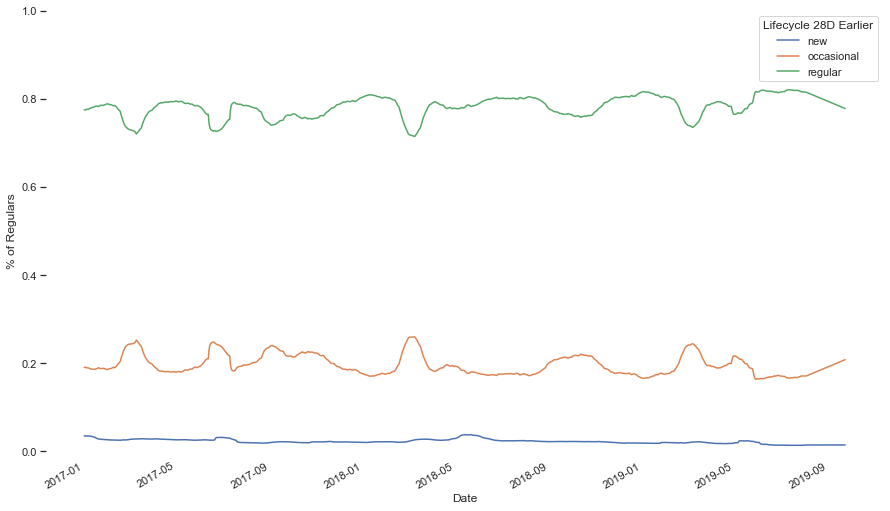

In [271]:
fig, ax = plt.subplots(figsize=(15,9))
viewer_transitions_28d.query('end_state == "regular"').merge(regulars, how='left', on='day') \
                      .eval('prob_start = x / total') \
                      .pivot_table(index='day',
                                   columns='start_state',
                                   values='prob_start') \
                      .plot(ax=ax)
ax.legend(title='Lifecycle 28D Earlier')
ax.tick_params(bottom=False, left=True)
ax.set(**{'frame_on': False,
          'ylim': [0, 1],
          'xlabel': 'Date',
          'ylabel': '% of Regulars'})
plt.show()

In [273]:
premium_hw_by_lifecycle = pd.read_csv('/stats/central_science/'
                                      'hw_trends/premium_hw_by_lifecycle.csv', parse_dates=['Time'])
premium_hw_by_lifecycle.head()

,Viewer Lifecycle Stage,Time,Total Hours Watched
0,regular,2015-08-01,47329635.81
1,regular,2015-09-01,26343492.45
2,regular,2015-10-01,55879121.07
3,regular,2015-11-01,35443762.30
4,regular,2015-12-01,29023522.13


In [277]:
premium_hw_by_lifecycle = premium_hw_by_lifecycle.rename(
    {
        'Time': 'month',
        'Viewer Lifecycle Stage': 'lifecycle',
        'Total Hours Watched': 'hw'
    }, axis='columns'
) 
premium_hw_by_lifecycle['hw_growth'] = premium_hw_by_lifecycle \
                                                 .groupby('lifecycle')['hw'] \
                                                 .apply(lambda x: x - x.shift())

In [279]:
premium_total = premium_hw_by_lifecycle.groupby('month').agg(growth_total=('hw_growth', 'sum'))

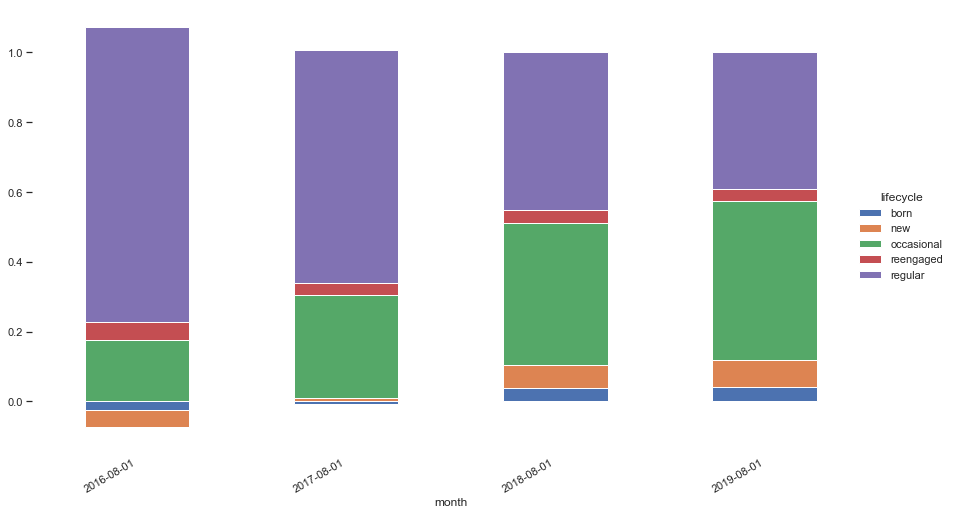

In [375]:
fig, ax = plt.subplots(figsize=(15,9))

premium_hw_by_lifecycle.merge(premium_total, how='left', on='month') \
  .eval('prop_growth = hw_growth / growth_total') \
  .query(
    '(month >= "2016-07-31" & month < "2016-09-01") |'
    '(month >= "2017-07-31" & month < "2017-09-01") |'
    '(month >= "2018-07-31" & month < "2018-09-01") |'
    '(month >= "2019-07-31" & month < "2019-09-01")') \
  .groupby(['month', 'lifecycle'])['prop_growth'] \
  .sum() \
  .unstack() \
  .plot(kind='bar', stacked=True, ax=ax)

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 0.6), frameon=False, title='lifecycle')
ax.tick_params(bottom=False, left=True)
ax.set(**{
    'frame_on': False,
    'xticklabels': [pd.to_datetime(x.get_text()).date() for x in ax.get_xticklabels()]
})

fig.autofmt_xdate();

In [470]:
hw_by_game = pd.read_csv('/stats/central_science/hw_trends/prop_hw_by_game.csv',
                        parse_dates=['month'])
hw_by_game.head()

,month,prop_hw_top1,prop_hw_top5,prop_hw_top20,prop_hw_top100
0,2015-01-01,0.000000,0.000000,0.000000,0.000000
1,2015-02-01,0.256414,0.541239,0.747942,0.871684
2,2015-03-01,0.247598,0.565151,0.709683,0.854294
3,2015-04-01,0.241306,0.554192,0.733450,0.866686
4,2015-05-01,0.231905,0.565305,0.747160,0.872145


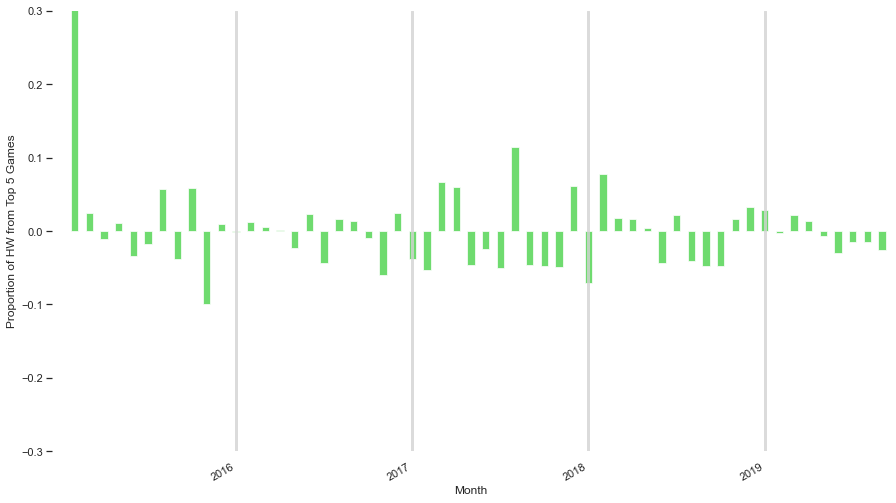

In [494]:
fig, ax = plt.subplots(figsize=(15,9))
hw_by_game.assign(diff5=hw_by_game['prop_hw_top5'] - hw_by_game['prop_hw_top5'].shift()) \
          .plot.bar(y='diff5', ax=ax, color='limegreen', alpha=.7)

for date in [i for i, x in enumerate(hw_by_game['month']) if x.month == 1][1:]:
    ax.axvline(date, *(0, 1), lw=3, alpha=0.8, color='lightgray')
ax.set(**{
    'frame_on': False,
    'ylim': (-.3,.3),
    'xticklabels': [f'{x:%Y}' if x.month == 1 and x.year > 2015 else '' for x in hw_by_game['month']],
    'ylabel': 'Proportion of HW from Top 5 Games',
    'xlabel': 'Month'
})
ax.tick_params(bottom=False, left=True)
ax.legend([], frameon=False)
fig.autofmt_xdate()
plt.show()

In [496]:
hw_per_mvv = pd.read_csv('/stats/central_science/hw_trends/hw_per_mvv.csv',
                        parse_dates=['month']) 
hw_per_mvv.head()

,lifecycle,month,hw_per_mvv
0,born,2017-04-01,0.263988
1,born,2017-05-01,0.255681
2,born,2017-06-01,0.248012
3,born,2017-07-01,0.237186
4,born,2017-08-01,0.254708


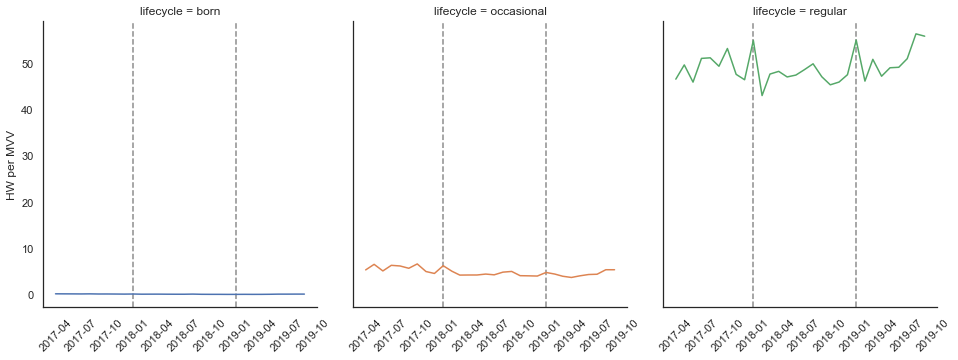

In [556]:
import matplotlib.ticker as mticker

g = sns.FacetGrid(hw_per_mvv[hw_per_mvv['lifecycle'].isin(['regular', 'occasional', 'born'])],
                  col='lifecycle',
                  hue='lifecycle',
                  height=5,
                  aspect=0.9,
                  margin_titles=True)
g.map(plt.axvline, x=pd.to_datetime('2018-01-01'), ls='--', c='k', alpha=.5)
g.map(plt.axvline, x=pd.to_datetime('2019-01-01'), ls='--', c='k', alpha=.5)
g.map(sns.lineplot, 'month', 'hw_per_mvv')
g.set_axis_labels('', 'HW per MVV')

xformatter = mdates.DateFormatter("%m-%Y")
g.axes[0,0].xaxis.set_major_formatter(xformatter)
#g.axes[0,0].xaxis.set_major_locator(mticker.MaxNLocator(8))
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

In [557]:
regular_days = pd.read_csv('/stats/central_science/hw_trends/power_user_data.csv')
regular_days.head()

,lifecycle,month,active_days,count
0,Regular,Dec,0,119257
1,Regular,Dec,1,51431
2,Regular,Dec,2,56582
3,Regular,Dec,3,67508
4,Regular,Dec,4,79288


In [558]:
regular_totals = regular_days.groupby('month').agg(total=('count', 'sum'))

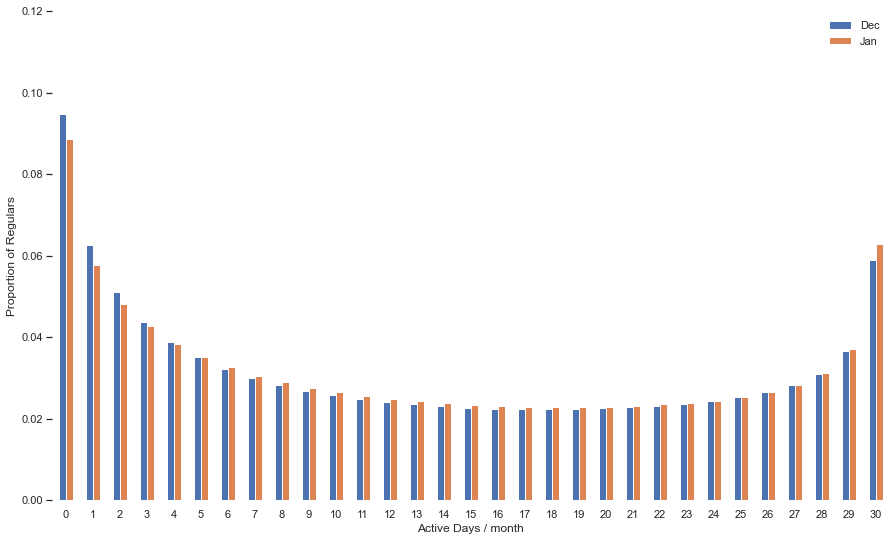

In [582]:
fig, ax = plt.subplots(figsize=(15,9))

regular_days.merge(regular_totals, how='left', on='month') \
          .eval('prop = count / total') \
          .groupby(['month', 'active_days'])['prop'].sum().unstack('month').plot.bar(rot=0, ax=ax)

ax.set(**{
    'frame_on': False,
    'ylim': (0,.12),
    'ylabel': 'Proportion of Regulars',
    'xlabel': 'Active Days / month'
})
ax.tick_params(bottom=False, left=True)
ax.legend(frameon=False)
plt.show()

In [583]:
power_users = pd.read_csv('/stats/central_science/hw_trends/power_user_data.csv')
power_users.head()

,lifecycle,month,active_days,count
0,Regular,Dec,0,119257
1,Regular,Dec,1,51431
2,Regular,Dec,2,56582
3,Regular,Dec,3,67508
4,Regular,Dec,4,79288


In [584]:
regular_totals = power_users.query('lifecycle == "Regular"').groupby('month').agg(total=('count', 'sum'))

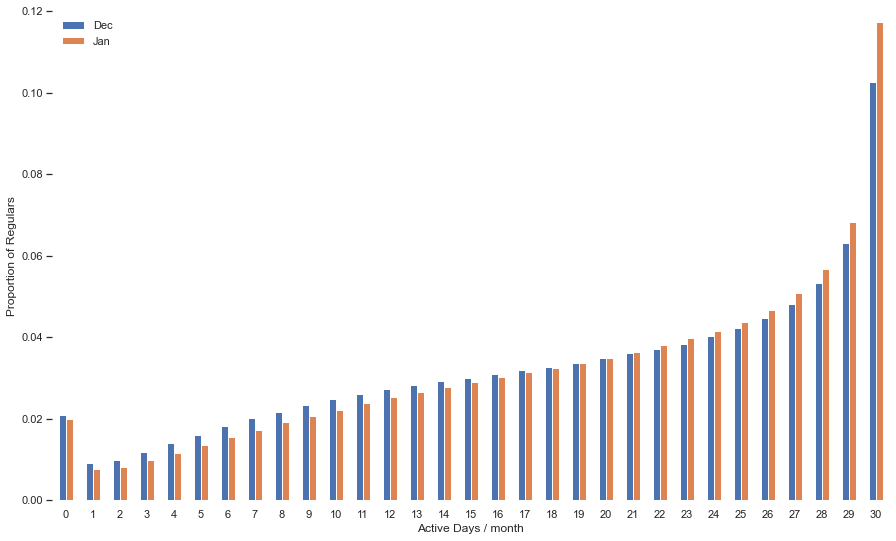

In [591]:
fig, ax = plt.subplots(figsize=(15,9))

power_users.query('lifecycle == "Regular"') \
          .merge(regular_totals, how='left', on='month') \
          .eval('prop = count / total') \
          .groupby(['month', 'active_days'])['prop'].sum() \
          .unstack('month').plot.bar(rot=0, ax=ax)

ax.set(**{
    'frame_on': False,
    'ylim': (0,.12),
    'ylabel': 'Proportion of Regulars',
    'xlabel': 'Active Days / month'
})
ax.tick_params(bottom=False, left=True)
ax.legend(frameon=False)
plt.show()

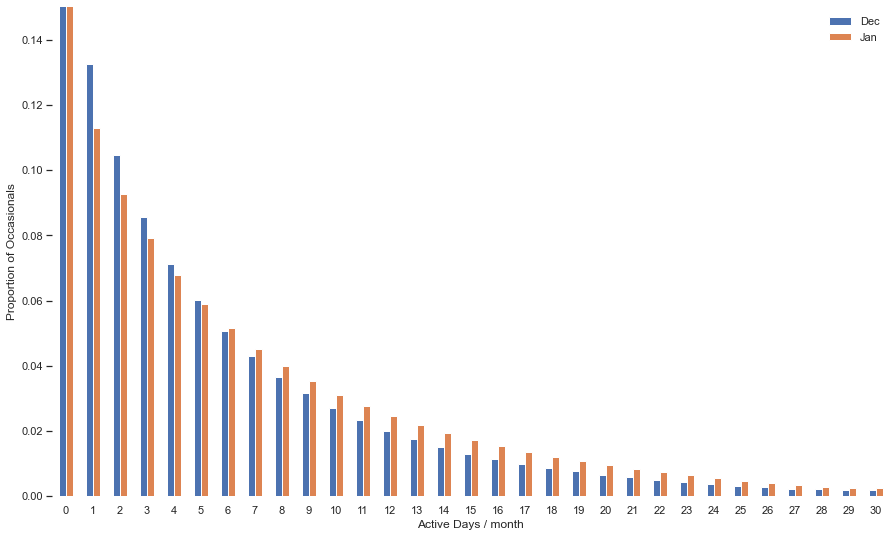

In [592]:
occasional_totals = power_users.query('lifecycle == "Occasional"').groupby('month').agg(total=('count', 'sum'))

fig, ax = plt.subplots(figsize=(15,9))

power_users.query('lifecycle == "Occasional"') \
          .merge(occasional_totals, how='left', on='month') \
          .eval('prop = count / total') \
          .groupby(['month', 'active_days'])['prop'].sum() \
          .unstack('month').plot.bar(rot=0, ax=ax)

ax.set(**{
    'frame_on': False,
    'ylim': (0,.15),
    'ylabel': 'Proportion of Occasionals',
    'xlabel': 'Active Days / month'
})
ax.tick_params(bottom=False, left=True)
ax.legend(frameon=False)
plt.show()

In [2]:
fr = pd.read_csv('/stats/central_science/hw_trends/fresh_regulars_account_age.csv')
fr.head()

,account_age,lifecycle,streak_start,count
0,F. <7 days,regular,December,134730
1,D. 31-90 days,regular,December,67520
2,B. 1-2 years,regular,December,48742
3,E. 8-30 days,regular,December,34350
4,C. 91 days - 1 year,regular,December,169081


In [3]:
regulars = fr.query('lifecycle == "regular"')
occasionals = fr.query('lifecycle == "occasional"')

In [5]:
fr_counts = regulars.groupby('streak_start').agg(total=('count', 'sum'))

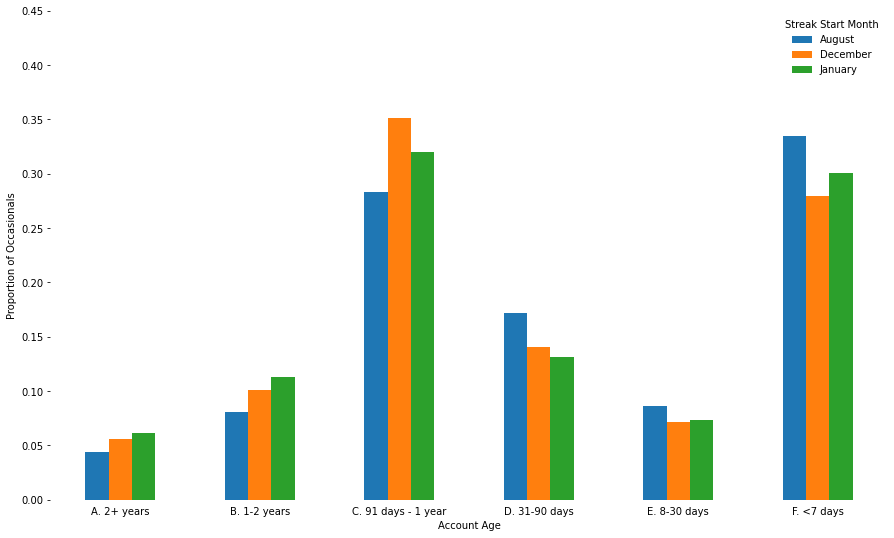

In [14]:
fig, ax = plt.subplots(figsize=(15,9))

regulars.merge(fr_counts, how='left', on='streak_start') \
        .eval('prop_total = count / total') \
        .pivot_table(index='account_age', columns='streak_start', values='prop_total') \
        .plot.bar(ax=ax, rot=0)
ax.set(**{
    'frame_on': False,
    'ylim': (0,.45),
    'ylabel': 'Proportion of Occasionals',
    'xlabel': 'Account Age'
})
ax.tick_params(bottom=False, left=True)
ax.legend(frameon=False, title='Streak Start Month')
plt.show()

In [27]:
start_mb = hb_vs_viewers.loc[hb_vs_viewers['day'] == hb_vs_viewers['day'].min(), 'minutes_broadcast'][0]
start_creators = hb_vs_viewers.loc[hb_vs_viewers['day'] == hb_vs_viewers['day'].min(), 'creators_live'][0]
start_visitors = hb_vs_viewers.loc[hb_vs_viewers['day'] == hb_vs_viewers['day'].min(), 'visitors'][0]

In [29]:
hb_vs_viewers

,day,minutes_broadcast,creators_live,visitors
0,2015-11-01,23353435,188134,11124724.0
1,2015-11-02,20554559,165973,8987423.0
2,2015-11-03,20959362,166376,9179076.0
3,2015-11-04,20735175,166246,8997203.0
4,2015-11-05,22480754,192565,9926481.0
...,...,...,...,...
1211,2019-02-24,81676769,541618,35183749.0
1212,2019-02-25,69656371,466826,28299233.0
1213,2019-02-26,69314400,462191,28516932.0
1214,2019-02-27,69438448,466231,45963788.0


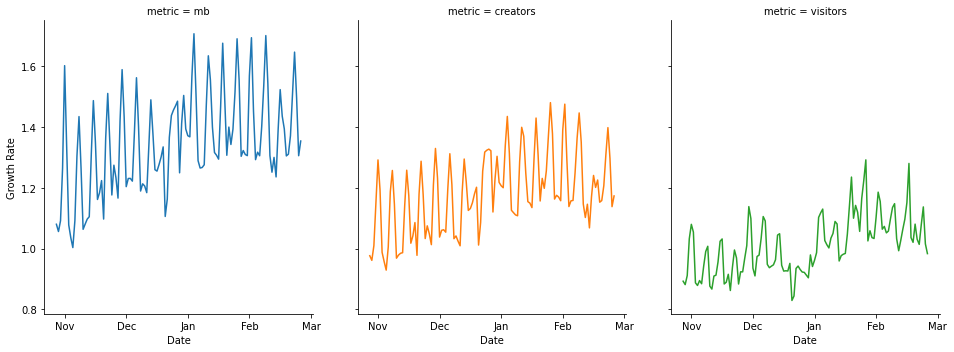

In [46]:
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

g = sns.FacetGrid(hb_vs_viewers.eval('mb = minutes_broadcast / @start_mb') \
                               .eval('creators = creators_live / @start_creators') \
                               .eval('visitors = visitors / @start_visitors') \
                               .melt(
                                  id_vars=['day', 'minutes_broadcast', 'creators_live'],
                                  value_vars=['mb', 'creators', 'visitors'],
                                  var_name='metric',
                                  value_name='count') \
                               .query('day >= "2016-11-01" & day < "2017-03-01"'),
                  col='metric',
                  hue='metric',
                  height=5,
                  aspect=0.9,
                  margin_titles=True)
g.map(sns.lineplot, 'day', 'count')
g.set_axis_labels('Date', 'Growth Rate')

xformatter = mdates.DateFormatter("%b")
g.axes[0,0].xaxis.set_major_formatter(xformatter)
g.axes[0,0].xaxis.set_major_locator(mticker.MaxNLocator(5))

In [63]:
daily_signups = pd.read_csv('/stats/central_science/hw_trends/users_sample.csv',
                           parse_dates=['created_on'])
daily_signups.head()

,user_id,created_on,birthday
0,279434371,2018-11-30 08:00:00+00:00,1976-06-11
1,272508636,2018-11-05 08:00:00+00:00,1999-04-14
2,279552822,2018-11-30 08:00:00+00:00,1996-09-16
3,403082980,2018-12-19 08:00:00+00:00,2000-12-17
4,409528689,2019-01-14 08:00:00+00:00,1800-01-01


In [8]:
daily_signups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   user_id     1000000 non-null  int64         
 1   created_on  1000000 non-null  datetime64[ns]
 2   birthday    0 non-null        datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 22.9 MB


In [64]:
daily_signups['created_on'] = daily_signups['created_on'].dt.tz_localize(None) # remove timezone
daily_signups['birthday'] = pd.to_datetime(daily_signups['birthday'], errors='coerce')

In [65]:
daily_signups.loc[daily_signups['birthday'].isna(), 'birthday'] = pd.to_datetime('1900-01-01')

In [13]:
# from sklearn.impute import SimpleImputer
# imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [66]:
daily_signups.loc[daily_signups['birthday'] < '1900-01-01', 'birthday'] = pd.to_datetime('1900-01-01')

In [67]:
daily_signups['age'] = ((daily_signups['created_on']
                                  - daily_signups['birthday']) / pd.Timedelta('365days')).astype(int)

In [68]:
age_group = pd.cut(daily_signups['age'],
                   [13,18,25,35,55],
                   labels=['13-17', '18-24', '25-34', '35-54']
                  ).values.add_categories('55+')
age_group = age_group.fillna('55+')
daily_signups['age_group'] = age_group

In [69]:
daily_signups = daily_signups.query('age < 85').groupby(['created_on', 'age_group']).size().reset_index(name='count')
daily_signups['created_on'] = daily_signups['created_on'].dt.date

In [70]:
daily_totals = daily_signups.groupby('created_on').agg(total=('count', 'sum'))

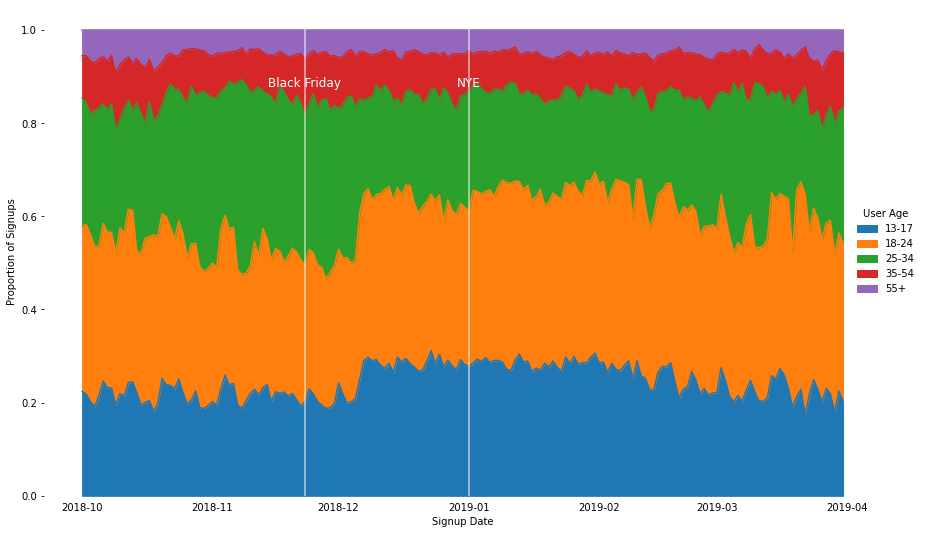

In [89]:
fig, ax = plt.subplots(figsize=(15,9))

daily_signups.merge(daily_totals, on='created_on', how='left') \
             .eval('age_prop = count / total') \
             .pivot_table(index='created_on', columns='age_group', values='age_prop') \
             .plot.area(ax=ax)

ax.axvline('2018-11-23', *(0, 1), lw=2, alpha=0.5, color='white')
ax.axvline('2019-01-01', *(0, 1), lw=2, alpha=0.5, color='white')
ax.text('2018-11-23', 0.9, 'Black Friday', size='large', ha='center', va='top', color='white')
ax.text('2019-01-01', 0.9, 'NYE', size='large', ha='center', va='top', color='white')

ax.set(**{
    'frame_on': False,
    'ylabel': 'Proportion of Signups',
    'xlabel': 'Signup Date'
})
ax.tick_params(bottom=False, left=True)
ax.legend(frameon=False, title='User Age', loc='center right',  bbox_to_anchor=(1.05, 0.5))
plt.show()